In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

sns.set_style('darkgrid')

In [2]:
df = pd.read_csv('netflix_titles.csv')

In [4]:
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...


In [7]:
df['director'] = df['director'].fillna('Unknown')
df['cast'] = df['cast'].fillna('Unknown')

In [8]:
df['country'] = df['country'].fillna(df['country'].mode()[0])

In [9]:
df.dropna(subset=['date_added','rating'], inplace=True)

In [10]:
df.isnull().sum()

show_id         0
type            0
title           0
director        0
cast            0
country         0
date_added      0
release_year    0
rating          0
duration        0
listed_in       0
description     0
dtype: int64

In [11]:
df['date_added'] = pd.to_datetime(df['date_added'], format='mixed', dayfirst=False)

In [12]:
df['year_added'] = df['date_added'].dt.year
df['month_added'] = df['date_added'].dt.month

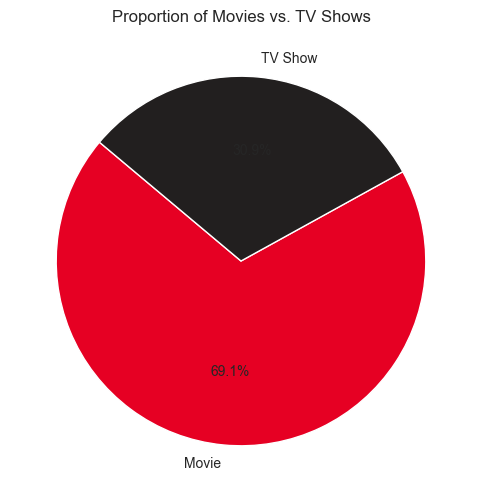

In [13]:
plt.figure(figsize=(8,6))
type_counts = df['type'].value_counts()
plt.pie(type_counts, labels=type_counts.index, autopct='%1.1f%%', startangle=140, colors=['#e60023', '#221f1f'])
plt.title('Proportion of Movies vs. TV Shows')
plt.ylabel('')
plt.show()

<Figure size 1200x800 with 0 Axes>

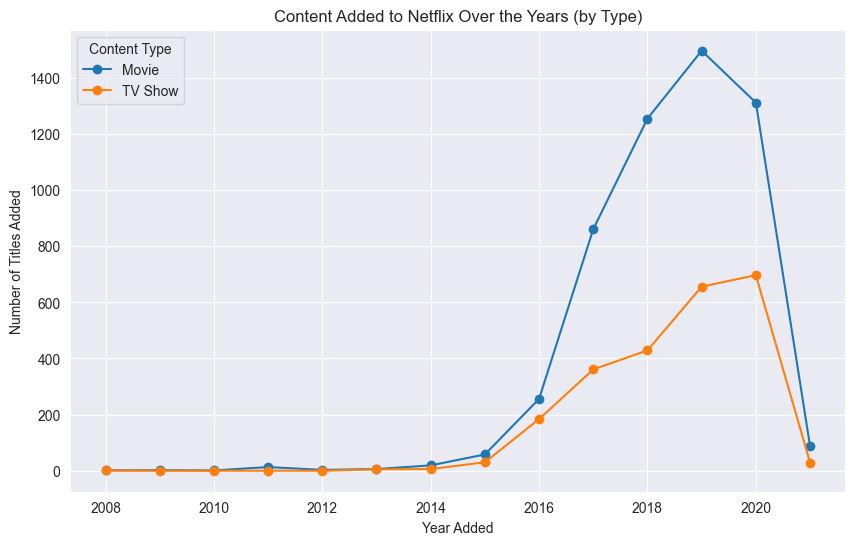

In [15]:
content_over_year = df.groupby(['year_added','type']).size().unstack().fillna(0)

plt.figure(figsize=(12,8))
content_over_year.plot(kind='line', marker = 'o', figsize=(10,6))
plt.title('Content Added to Netflix Over the Years (by Type)')
plt.xlabel('Year Added')
plt.ylabel('Number of Titles Added')
plt.legend(title='Content Type')
plt.grid(True)
plt.show()

In [16]:
genres = df.assign(genre = df['listed_in'].str.split(', ')).explode('genre')

In [17]:
top_genres_counts = genres['genre'].value_counts().reset_index()
top_genres_counts.columns = ['Genre','Counts']

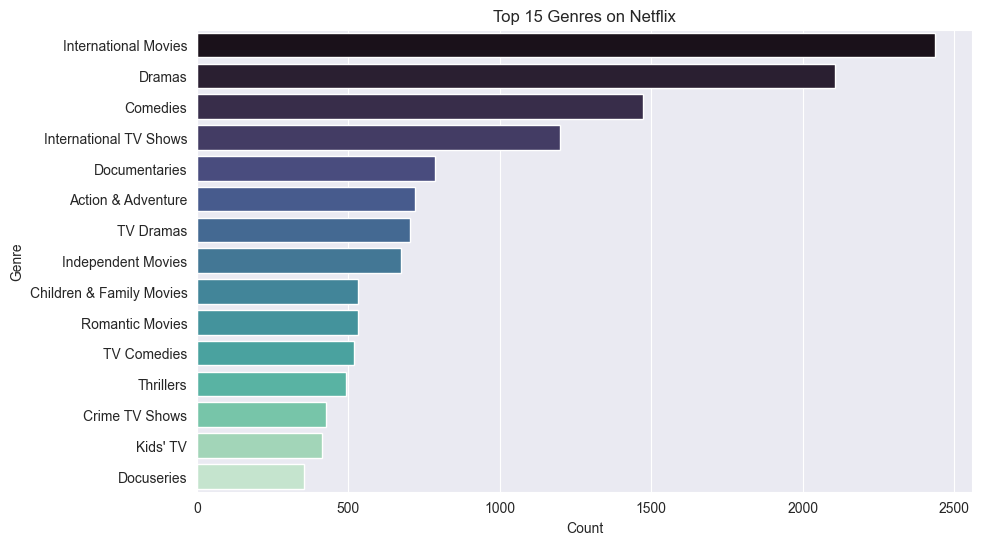

In [20]:
top_genres_counts_plot = top_genres_counts.head(15)
plt.figure(figsize=(10, 6))
sns.barplot(y='Genre', x='Counts', data=top_genres_counts_plot, palette='mako', hue='Genre', legend=False)
plt.title('Top 15 Genres on Netflix')
plt.xlabel('Count')
plt.ylabel('Genre')
plt.show()

In [21]:
movies_df = df[df['type']=='Movie'].copy()
tv_shows_df = df[df['type']=='TV Show'].copy()

In [22]:
movies_df['duration_min'] = movies_df['duration'].str.replace(' min','').astype(int)

In [25]:
tv_shows_df['seasons'] = tv_shows_df['duration'].str.replace(' Seasons','').str.replace(' Season','').astype(int)

In [26]:
tv_shows_df['seasons'].value_counts().index

Index([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 15, 12, 13, 16], dtype='int64', name='seasons')

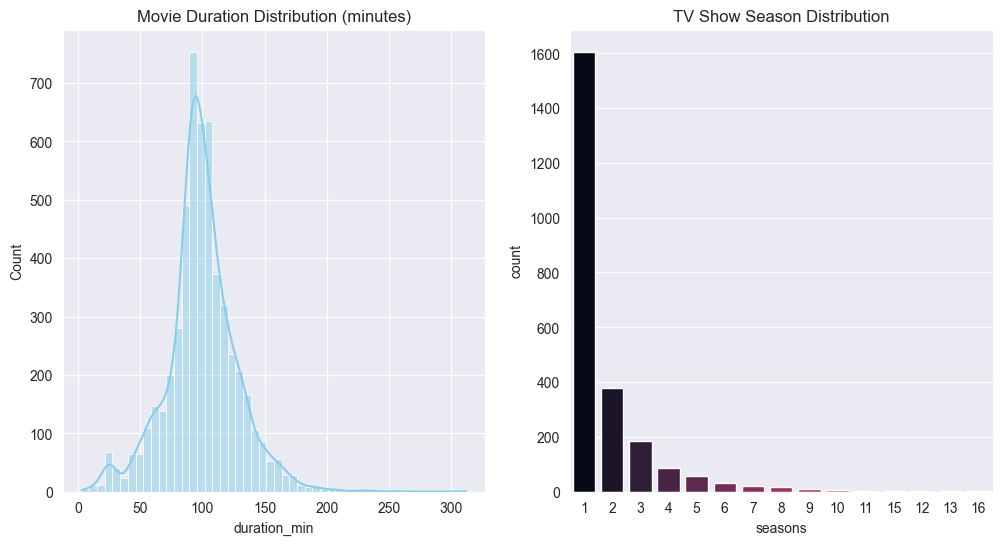

In [27]:
# Plot the distributions
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Movie Duration Distribution
sns.histplot(ax=axes[0], data=movies_df, x='duration_min', bins=50, kde=True, color='skyblue').set_title('Movie Duration Distribution (minutes)')

# TV Show Season Distribution
sns.countplot(ax=axes[1], x='seasons', data=tv_shows_df, palette='rocket', order=tv_shows_df['seasons'].value_counts().index, hue='seasons', legend=False).set_title('TV Show Season Distribution')

plt.show()

In [28]:
countries = df.assign(country=df['country'].str.split(', ')).explode('country')

In [29]:
# Get the top 15 countries and their counts
top_countries_counts = countries['country'].value_counts().reset_index()
top_countries_counts.columns = ['country', 'count'] # Rename columns for clarity

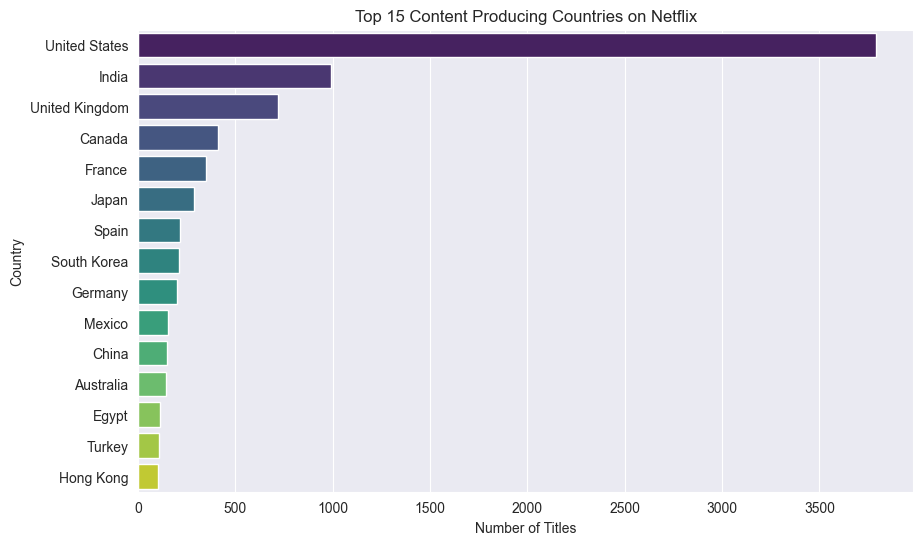

In [30]:
# Select only the top 15 for plotting
top_countries_counts_plot = top_countries_counts.head(15)

plt.figure(figsize=(10, 6))
sns.barplot(y='country', x='count', data=top_countries_counts_plot, palette='viridis', hue='country', legend=False)
plt.title('Top 15 Content Producing Countries on Netflix')
plt.xlabel('Number of Titles')
plt.ylabel('Country')
plt.show()

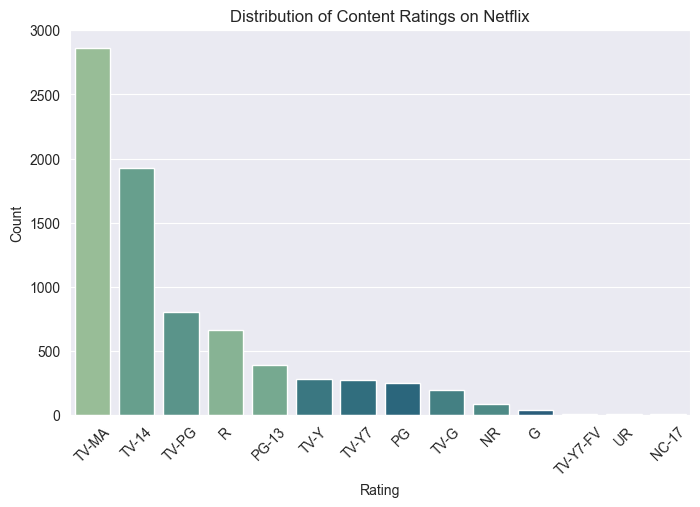

In [31]:
plt.figure(figsize=(8, 5))
sns.countplot(x='rating', data=df, order=df['rating'].value_counts().index, palette='crest', hue='rating', legend=False)
plt.title('Distribution of Content Ratings on Netflix')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [32]:
df['age_on_netflix'] = df['year_added'] - df['release_year']

In [33]:
# Filter out any potential errors where added_year is before release_year
content_age = df[df['age_on_netflix'] >= 0]

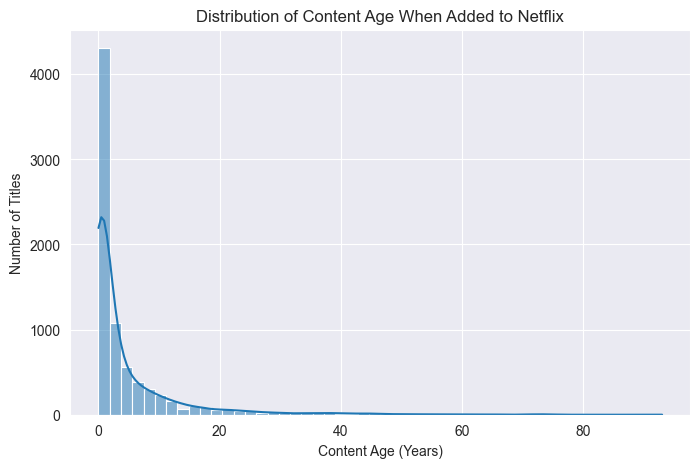

In [34]:
plt.figure(figsize=(8, 5))
sns.histplot(data=content_age, x='age_on_netflix', bins=50, kde=True)
plt.title('Distribution of Content Age When Added to Netflix')
plt.xlabel('Content Age (Years)')
plt.ylabel('Number of Titles')
plt.show()

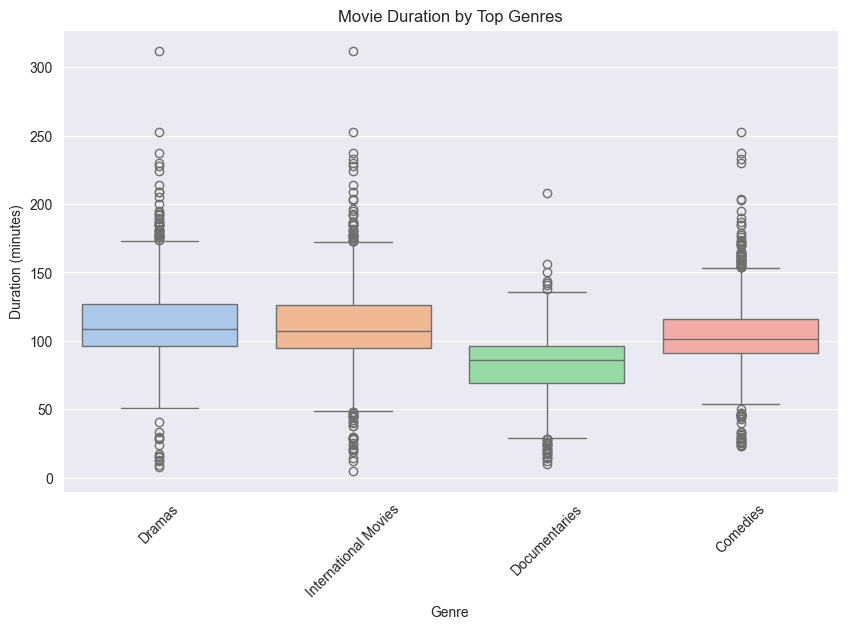

In [35]:
# Analyze movie duration across different top genres
top_genres = genres['genre'].value_counts().index[:5]
genres_movies = genres[(genres['type'] == 'Movie') & (genres['genre'].isin(top_genres))].copy()
genres_movies['duration_min'] = genres_movies['duration'].str.replace(' min', '').astype(int)

plt.figure(figsize=(10, 6))
sns.boxplot(data=genres_movies, x='genre', y='duration_min', palette='pastel', hue='genre', legend=False)
plt.title('Movie Duration by Top Genres')
plt.xlabel('Genre')
plt.ylabel('Duration (minutes)')
plt.xticks(rotation=45)
plt.show()

In [36]:
text = ' '.join(df['description'])

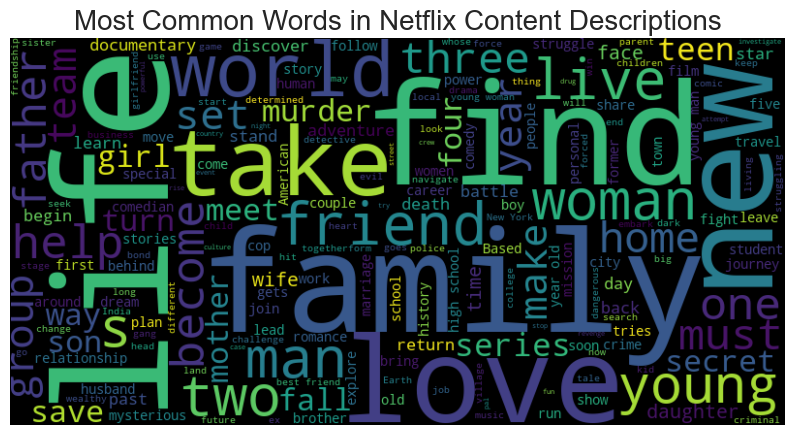

In [37]:
wordcloud = WordCloud(width=800,height=400,background_color='black').generate(text)
# Display the generated image
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Netflix Content Descriptions', fontsize=20)
plt.show()

<Figure size 1400x800 with 0 Axes>

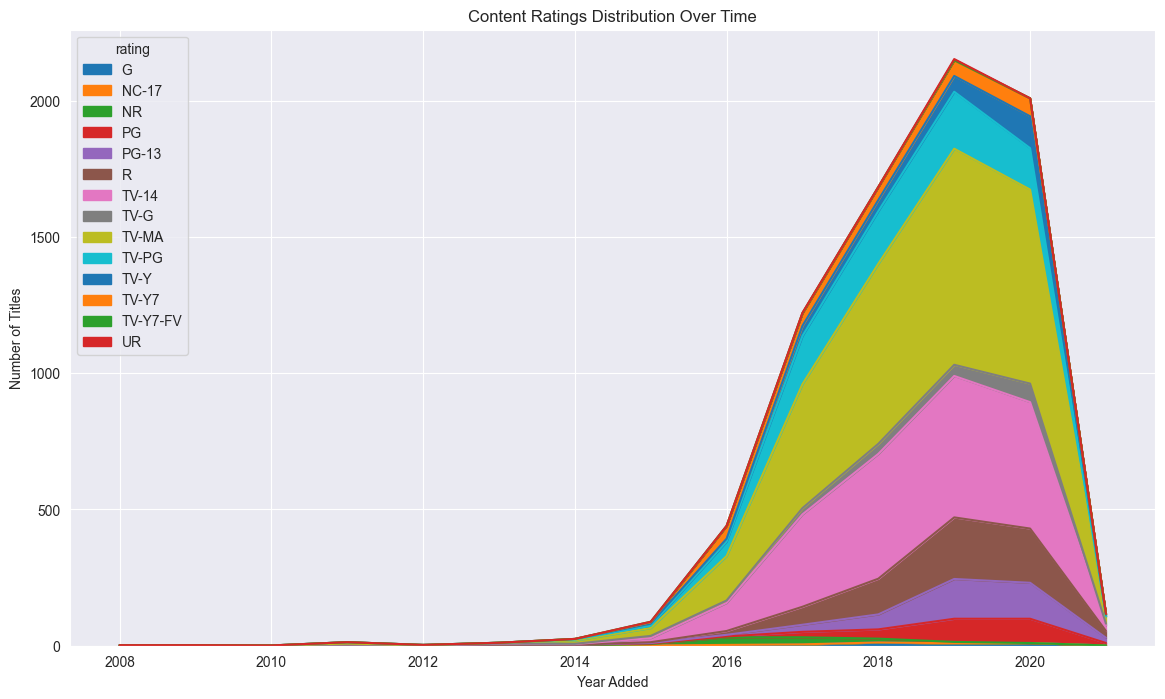

In [39]:
rating_over_time = df.groupby(['year_added', 'rating']).size().unstack().fillna(0)

plt.figure(figsize=(14, 8))
rating_over_time.plot(kind='area', stacked=True, figsize=(14, 8))
plt.title('Content Ratings Distribution Over Time')
plt.xlabel('Year Added')
plt.ylabel('Number of Titles')
plt.show()


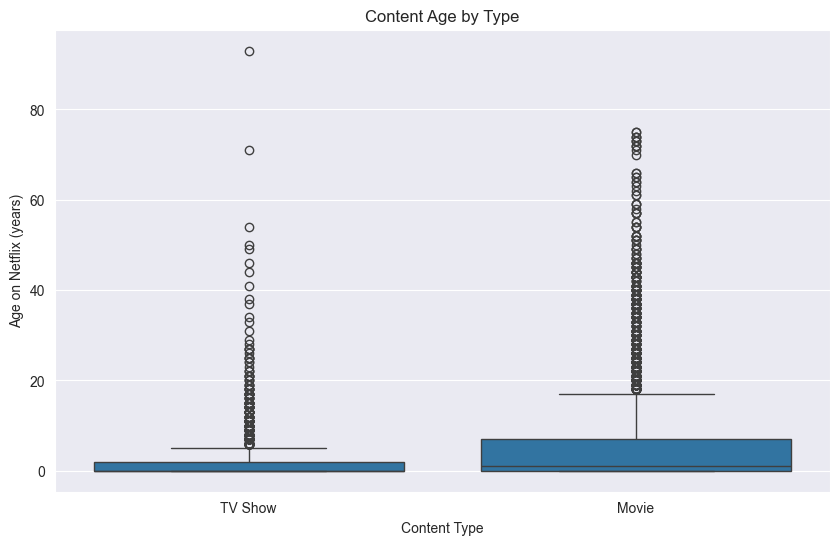

In [40]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='type', y='age_on_netflix', data=content_age)
plt.title('Content Age by Type')
plt.xlabel('Content Type')
plt.ylabel('Age on Netflix (years)')
plt.show()


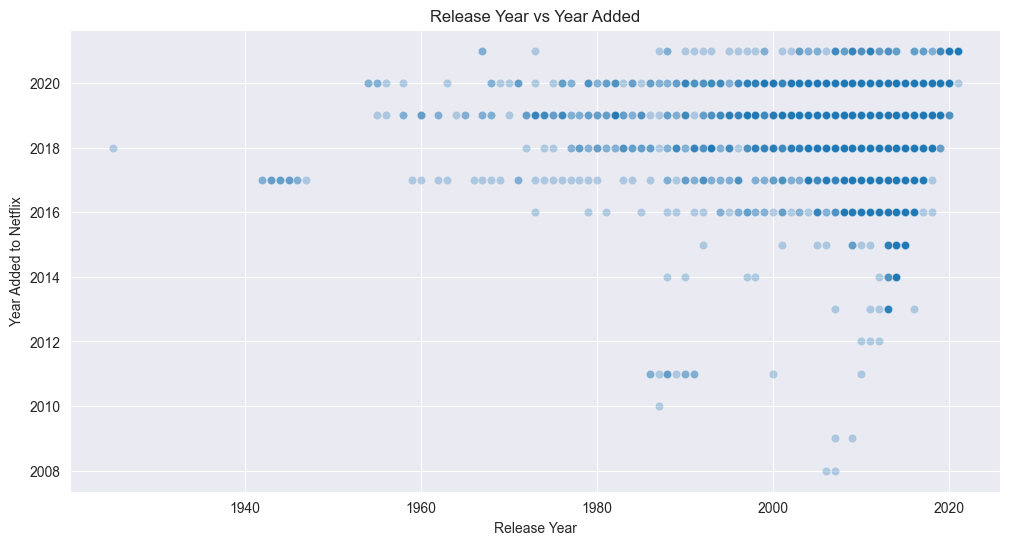

In [42]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='release_year', y='year_added', data=df, alpha=0.3)
plt.title('Release Year vs Year Added')
plt.xlabel('Release Year')
plt.ylabel('Year Added to Netflix')
plt.show()


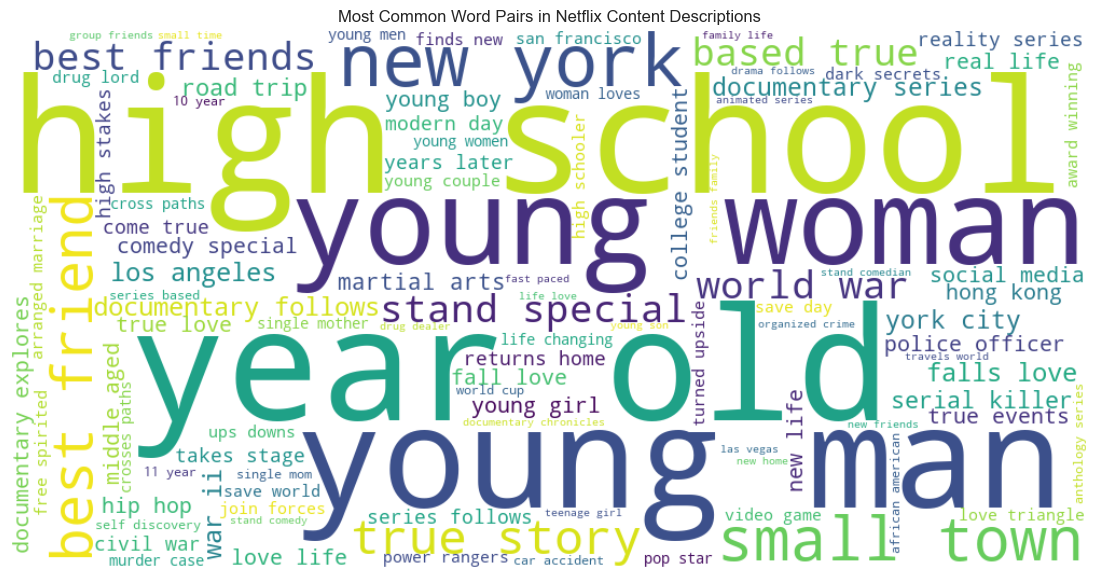

In [48]:
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Create bigrams from descriptions
vectorizer = CountVectorizer(
    stop_words='english',
    ngram_range=(2, 2),
    max_features=100
)

X = vectorizer.fit_transform(df['description'])

# Get bigram frequencies
word_freq = dict(
    zip(
        vectorizer.get_feature_names_out(),
        X.toarray().sum(axis=0)
    )
)

# Generate WordCloud
wordcloud = WordCloud(
    width=1000,
    height=500,
    background_color='white'
).generate_from_frequencies(word_freq)

# Plot
plt.figure(figsize=(14, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Word Pairs in Netflix Content Descriptions')
plt.show()

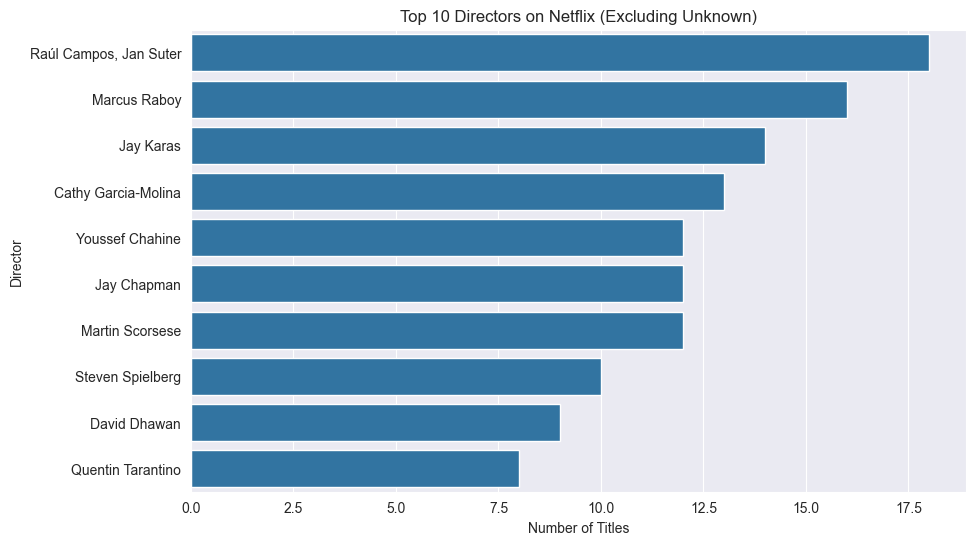

In [46]:
top_directors = (
    df[df['director'] != 'Unknown']
    ['director']
    .value_counts()
    .head(10)
)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_directors.values, y=top_directors.index)
plt.title('Top 10 Directors on Netflix (Excluding Unknown)')
plt.xlabel('Number of Titles')
plt.ylabel('Director')
plt.show()
